# Lid driven cavity

In this notebook we use Physics Informed Neural Networks (PINNS) to solve the Navier-Stokes equations in a rectangular domain. The Navier-Stokes problem to solve is

\begin{align*}
(\boldsymbol{u} \cdot \nabla) \boldsymbol{u} - \nu \nabla^2 \boldsymbol{u} + \nabla p &= 0, \quad \boldsymbol{x} \in \Omega = (-1, 1)^2\\
\nabla \cdot \boldsymbol{u} &= 0, \quad \boldsymbol{x} \in \Omega = (-1, 1)^2 \\
\end{align*}

where $\nu$ is a constant kinematic viscosity, $p(\boldsymbol{x})$ is pressure, $\boldsymbol{u}(\boldsymbol{x}) = u_x(\boldsymbol{x}) \boldsymbol{i} + u_y(\boldsymbol{x}) \boldsymbol{j}$ is the velocity vector and the position vector $\boldsymbol{x} = x \boldsymbol{i} + y \boldsymbol{j}$, with unit vectors $\boldsymbol{i}$ and $\boldsymbol{j}$. The Dirichlet boundary condition for the velocity vector is zero everywhere, except for the top lid, where $\boldsymbol{u}(x, y=1) = (1-x)^2(1+x)^2 \boldsymbol{i}$. There is no boundary condition on pressure, but since the pressure is only present inside a gradient, it can only be found up to a constant. Hence, we specify that $p(x=0, y=0) = 0$.

We start the implementation by importing necessary modules such as [jax](https://docs.jax.dev/en/latest/index.html), [flax](https://flax.readthedocs.io/), where the latter is a module that provides neural networks for JAX.


In [1]:
# ruff: noqa: I001, E402
import jax
import jax.numpy as jnp
from flax import nnx

jax.config.update("jax_enable_x64", True)

We will solve the Navier-Stokes equations using a multilevel perceptron neural network, where the solution will be approximated as

$$
F_{\theta}(\boldsymbol{x}; \theta) =  W^{L} \sigma( W^{L-1} \ldots \sigma( W^1 \boldsymbol{x} + \boldsymbol{b}^1) \ldots + \boldsymbol{b}^{L-1})  + \boldsymbol{b}^L
$$

where $\theta = \{W^l, \boldsymbol{b}^l\}_{l=1}^L$ represents all the unknowns in the model and $W^l, \boldsymbol{b}^l$ represents the weights and biases on level $l$. The model contains both velocity components and the pressure, for a total of three scalar outputs: $u_{x}(\boldsymbol{x}), u_y(\boldsymbol{x})$ and $p(\boldsymbol{x})$. Hence $F_{\theta}: \mathbb{R}^2 \rightarrow \mathbb{R}^3$.

We split the coupled $F_{\theta}$ into velocity and pressure

$$
F_{\theta} = \boldsymbol{u}_{\theta} \times p_{\theta}
$$

where $\boldsymbol{u}_{\theta}: \mathbb{R}^2 \rightarrow \mathbb{R}^2$ is a vector function and $p_{\theta}: \mathbb{R}^2 \rightarrow \mathbb{R}$ is a scalar function.

We start the implementation by creating multilayer perceptron functionspaces for $\boldsymbol{u}_{\theta}$ and $p_{\theta}$, and then combining these to a space for $F_{\theta}$ using a Cartesian product:


In [2]:
from jaxfun.pinns import FlaxFunction, MLPSpace, Comp

V = MLPSpace([16], dims=2, rank=1, name="V")  # Vector space for velocity
Q = MLPSpace([12], dims=2, rank=0, name="Q")  # Scalar space for pressure

u = FlaxFunction(V, "u", rngs=nnx.Rngs(2002))
p = FlaxFunction(Q, "p", rngs=nnx.Rngs(2002))
module = Comp(u, p)

Note that `u` and `p` both are `FlaxFunction`s, that are subclasses of the Sympy [Function](https://docs.sympy.org/latest/modules/functions/index.html). However, in Jaxfun these functions have some additional properties, that makes it easy to describe equations.

We can inspect `u` and `p`


In [3]:
from IPython.display import display

display(u)
display(u.doit())
display(p)
display(p.doit())

u(x, y; V)

(u_x(x, y))*N.i + (u_y(x, y))*N.j

p(x, y; Q)

p(x, y)

Note that `u` and `p` are in unevaluated state, whereas `u.doit()` and `p.doit()` returns sympy functions for the computational space. If we check the type of `u.doit()`, we get that it is a `VectorAdd`, because the vector is an addition of the two vector components in $(u_x(x, y))\boldsymbol{i} + (u_y(x, y)) \boldsymbol{j}$. The three terms $u_x(x, y), u_y(x, y)$ and $p(x, y)$ are all sympy functions and of type `AppliedUndef`.


In [4]:
display(type(u.doit()))
display(type(p.doit()))

sympy.vector.vector.VectorAdd

p

We can now describe the Navier-Stokes equations using `Div`, `Grad` and `Dot` from Jaxfun. First specify the Reynolds number, the kinematic viscosity and then the equations


In [5]:
import sympy as sp
from jaxfun.operators import Div, Dot, Grad, Constant

Re = 10.0  # Define Reynolds number
nu = Constant(
    "nu", 2.0 / Re
)  # Define kinematic viscosity. A number works as well, but the Constant prints better.
R1 = Dot(Grad(u), u) - nu * Div(Grad(u)) + Grad(p)
# I = Identity(VQ.system)
#
# R1 = Div(Outer(u, u)) - Div(nu*(Grad(u) + Grad(u).T - sp.Rational(2, 3)*Div(u)*I) + p*I)  # noqa: E501
R2 = Div(u)

Here `R1` represents the residual of the momentum vector equation $\mathcal{R}^1_{\theta}$, whereas `R2` represents the residual of the scalar divergence constraint $\mathcal{R}^2_{\theta}$.


We can inspect the residuals:


In [6]:
R1

-nu*Div(Grad(u(x, y; V))) + Dot(Grad(u(x, y; V)), u(x, y; V)) + Grad(p(x, y; Q))

`R1` represents a vector equation and we can expand it using `doit`:


In [7]:
R1.doit()

(u_x(x, y)*Derivative(u_x(x, y), x) + u_y(x, y)*Derivative(u_x(x, y), y) + Derivative(p(x, y), x) - 0.2*Derivative(u_x(x, y), (x, 2)) - 0.2*Derivative(u_x(x, y), (y, 2)))*N.i + (u_x(x, y)*Derivative(u_y(x, y), x) + u_y(x, y)*Derivative(u_y(x, y), y) + Derivative(p(x, y), y) - 0.2*Derivative(u_y(x, y), (x, 2)) - 0.2*Derivative(u_y(x, y), (y, 2)))*N.j

The divergence constraint is a scalar equation


In [8]:
display(R2)
display(R2.doit())

Div(u(x, y; V))

Derivative(u_x(x, y), x) + Derivative(u_y(x, y), y)

To solve the equations we will use a least squares method and for this we need to create collocation points both inside and on the domain. There are some simple helper functions in `jaxfun.pinns.mesh` that can help use create such points. Below we create a total of $N^2$ points in a rectangular mesh. We separate these points into $N_i=N^2-4N$ points `xyi` inside the domain $\boldsymbol{x}^{\Omega} = \{(x_i, y_i)\}_{i=0}^{N_i-1}$, and $N_b=4N$ points `xyb` on the boundary of the domain $\boldsymbol{x}^{\partial \Omega} = \{(x_i, y_i)\}_{i=0}^{4N-1}$, including the four corners. The last point `xyp` is simply origo and used to fix the pressure in a single point.


In [9]:
from jaxfun.pinns.mesh import Rectangle

N = 20
mesh = Rectangle(-1, 1, -1, 1)
xyi = mesh.get_points(N * N, 4 * N, domain="inside", kind="random")
xyb = mesh.get_points(N * N, 4 * N, domain="boundary", kind="random")
xyp = jnp.array([[0.0, 0.0]])

The boundary conditions on the velocity vector needs to be specified and to this end we can use the function `DirichletBC`:


In [10]:
from jaxfun.pinns.bcs import DirichletBC

x, y = V.system.base_scalars()
ub = DirichletBC(
    u, xyb, (sp.Piecewise((0, y < 1), ((1 - x) ** 2 * (1 + x) ** 2, True))), 0
)

Here `ub` is simply an array of numbers that will act as targets for the velocity vector on the chosen boundary points `xyb`. The target is called $\boldsymbol{u}_b$ below.

The unknowns will now be found using the least squares method, which is to minimize

\begin{equation*}
\underset{\theta \in \mathbb{R}^M}{\text{minimize}}\, L(\theta):=\frac{1}{N_i}\sum_{k=0}^1\sum_{i=0}^{N_i-1} \mathcal{R}^{1}_{\theta} (\boldsymbol{x}^{\Omega}_i)^2 \cdot \boldsymbol{i}_k + \frac{1}{N_i}\sum_{i=0}^{N_i-1} \mathcal{R}^{2}_{\theta}(\boldsymbol{x}^{\Omega}_i)^2+ \frac{1}{N_b} \sum_{k=0}^1 \sum_{i=0}^{N_b-1} (\boldsymbol{u}_{\theta}(\boldsymbol{x}^{\partial \Omega}_i) - \boldsymbol{u}_b(\boldsymbol{x}^{\partial \Omega}_i))^2 \cdot \boldsymbol{i}_k + p_{\theta}(0, 0)
\end{equation*}


where $\boldsymbol{i}_0 = \boldsymbol{i}$ and $\boldsymbol{i}_1 = \boldsymbol{j}$.
We define the minimization problem using the jaxfun class `Loss`, which takes as arguments tuples containing the residual, the collocation points to use for that residual, the target (defaults to zero) and optionally some weights. The weights may be constants or 1D arrays of length the number of collocation points. If weights are provided, then these are applied to the squared residuals in each term above. For example, the divergence loss becomes

$$
\frac{1}{N_i}\sum_{i=0}^{N_i-1} \omega_i \mathcal{R}^{2}_{\theta}(\boldsymbol{x}^{\Omega}_i)^2
$$

using weights $\{\omega_i\}_{i=0}^{N_i-1}$. Below the pressure anchor is simply weighted with a constant factor 10.


In [11]:
from jaxfun.pinns import Loss

loss_fn = Loss((R1, xyi), (R2, xyi), (u, xyb, ub), (p, xyp, 0, 10))

There are six scalar losses computed with `loss_fn`


In [12]:
loss_fn.residuals

Each loss may be computed individually, or we can compute the whole sum $L(\theta)$. Since we have not started the least squares solver yet, the module for now only contains randomly initialized weights and the loss is significant


In [13]:
loss_fn(module)

Array(0.26737551, dtype=float64)

To create a solver, we use the [optax](https://optax.readthedocs.io/en/latest/) module, and start with the Adam optimizer


In [14]:
from jaxfun.pinns.optimizer import Trainer, adam

trainer = Trainer(loss_fn)
opt_adam = adam(module)
trainer.train(opt_adam, 5000, epoch_print=1000)

Running optimizer Adam(lr=0.001)
Epoch 1000 Adam, loss: 0.0314705247671152
Epoch 2000 Adam, loss: 0.011278293504061811
Epoch 3000 Adam, loss: 0.0053545088284909625
Epoch 4000 Adam, loss: 0.0028787044926029117
Epoch 5000 Adam, loss: 0.002150708128936689


The loss has now been reduced, but is still far from zero.


In [15]:
loss_fn(module)

Array(0.00215326, dtype=float64)

To refine the solution, we use a low-memory BFGS solver:


In [16]:
from jaxfun.pinns.optimizer import lbfgs

opt_lbfgs = lbfgs(module, memory_size=100)
trainer.train(opt_lbfgs, 5000, epoch_print=1000)

Running optimizer LBFGS(memory_size=100)
Epoch 1000 LBFGS, loss: 0.00024192703709496267
Epoch 2000 LBFGS, loss: 0.00012854847714440534
Epoch 3000 LBFGS, loss: 8.764105461318429e-05
Epoch 4000 LBFGS, loss: 7.003024921253221e-05
Epoch 5000 LBFGS, loss: 5.1583915770987475e-05


In [17]:
loss_fn(module)

Array(5.15777483e-05, dtype=float64)

And finally a full Newton method, which is still quite slow because we have not yet implemented a preconditioner.


In [18]:
from jaxfun.pinns.optimizer import GaussNewton

opt_hess = GaussNewton(module, use_lstsq=False, cg_max_iter=100)
trainer.train(opt_hess, 100, epoch_print=10)

Running optimizer Hessian(lstsq=False)
Epoch 10 Hessian, loss: 4.796038359428407e-05
Epoch 20 Hessian, loss: 4.6133265104381976e-05
Epoch 30 Hessian, loss: 4.418861021056122e-05
Epoch 40 Hessian, loss: 4.264232062651403e-05
Epoch 50 Hessian, loss: 4.1204172209478625e-05
Epoch 60 Hessian, loss: 3.985487233468753e-05
Epoch 70 Hessian, loss: 3.8416748494757595e-05
Epoch 80 Hessian, loss: 3.7185366641114256e-05
Epoch 90 Hessian, loss: 3.60712720447941e-05
Epoch 100 Hessian, loss: 3.507170989875835e-05


We can now visualize the solution using [matplotlib](https://matplotlib.org/)


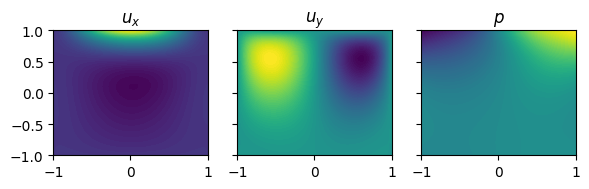

In [19]:
import matplotlib.pyplot as plt

yj = jnp.linspace(-1, 1, 50)
xx, yy = jnp.meshgrid(yj, yj, sparse=False, indexing="ij")
z = jnp.column_stack((xx.ravel(), yy.ravel()))
uvp = module(z)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6, 2))
axs[0].contourf(xx, yy, uvp[:, 0].reshape(xx.shape), 100)
axs[0].set_title(r"$u_x$")
axs[1].contourf(xx, yy, uvp[:, 1].reshape(xx.shape), 100)
axs[1].set_title(r"$u_y$")
axs[2].contourf(xx, yy, uvp[:, 2].reshape(xx.shape), 100)
axs[2].set_title(r"$p$")
fig.set_tight_layout("tight")

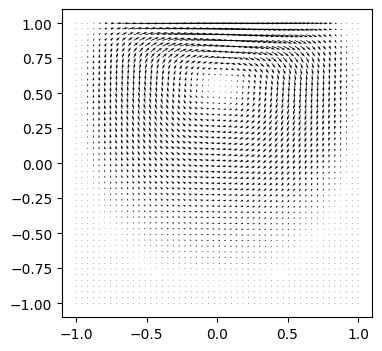

In [20]:
plt.figure(figsize=(4, 4))
plt.quiver(xx, yy, uvp[:, 0].reshape(xx.shape), uvp[:, 1].reshape(xx.shape));

We can also compute the losses of each equation. Here we get the loss of each collocation point in $\boldsymbol{x}^{\Omega}$ for the momentum equation in the x-direction:


In [21]:
loss_fn.compute_residual_i(module, 0)

Array([ 1.05766231e-03,  2.56621801e-03, -2.43358748e-03, -3.94696854e-03,
       -4.15586924e-04, -2.23845144e-03,  8.86103293e-05, -2.82789677e-03,
        1.85697122e-04, -1.57373809e-04, -1.20427255e-03, -8.05681442e-04,
        3.32004762e-04, -8.80514887e-04,  7.28667772e-05,  1.17867634e-03,
       -1.13237783e-03, -2.68096448e-03, -3.14967416e-04,  2.91453027e-03,
       -2.14101960e-03,  9.98496288e-04, -8.92537247e-04, -3.29966185e-04,
        8.03682113e-04, -1.24339065e-03, -5.97078196e-04,  8.47413877e-04,
       -7.88784856e-04,  1.27198617e-03, -2.35872875e-03,  5.64124843e-04,
        3.69283934e-04,  2.17498075e-04,  1.88575460e-03, -1.18466540e-03,
       -1.82841084e-03, -3.66393924e-04,  1.99495088e-03,  4.44117167e-03,
       -1.00012813e-03,  1.80978494e-04, -3.86973044e-04, -1.11190314e-03,
       -8.31118321e-04,  3.82929103e-03, -1.48705234e-03,  2.20461187e-03,
       -4.67366338e-03,  1.60649848e-03,  1.05822099e-02,  8.87396219e-04,
        9.18620873e-04,  

The loss can be plotted using for example scatter. Below is the scatter plot of the error in the divergence constraint.


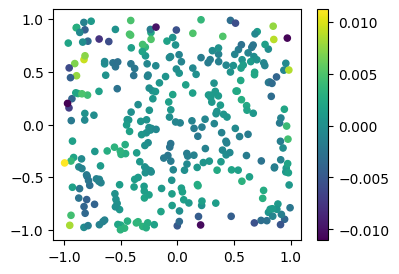

In [22]:
plt.figure(figsize=(4, 3))
plt.scatter(*xyi.T, c=loss_fn.compute_residual_i(module, 2), s=20)
plt.colorbar();

And finally a vector plot of the velocity vectors:


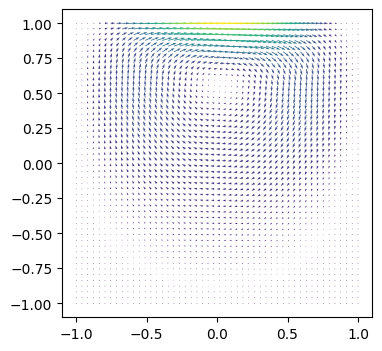

In [23]:
plt.figure(figsize=(4, 4))
plt.quiver(xx, yy, uvp[:, 0], uvp[:, 1], jnp.linalg.norm(uvp[:, :2], axis=1));